#Using concatenated heavy and light chain amino acid embeddings from Ablang to predict MAPT score using a CNN.

Heavy chain and light chain amino acid embeddings generated by Ablang will be used as features to predict MAPT score with a convolutional neural network for regression.


In [1]:
#@title Mount drive and load libraries
import os, pandas as pd, numpy as np
# from sklearn.metrics import r2_score
# import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


from google.colab import drive

drive.mount('/content/drive/')
path = '/content/drive/MyDrive/msc-project-mbalmf01/msc-project-source-code-files-22-23-mbalmf01/notebooks'
os.chdir(path)

from ML_manipulation import standardise, normalise, regression_nn, regression_report

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#@title Read in heavy and light chain per residue embeddings
f = '/content/drive/MyDrive/msc-project-mbalmf01/embeddings/230819_ablang_H_aa_embeddings_0.npy'
fl = '/content/drive/MyDrive/msc-project-mbalmf01/embeddings/230814_ablang_L_aa_embeddings_0.npy'
f2 = '/content/drive/MyDrive/msc-project-mbalmf01/embeddings/230819_ablang_H_aa_embeddings_1.npy'
fl2 = '/content/drive/MyDrive/msc-project-mbalmf01/embeddings/230814_ablang_L_aa_embeddings_1.npy'

md = np.load(f, mmap_mode='r')
mdl = np.load(fl, mmap_mode='r')
md2 = np.load(f2, mmap_mode='r')
mdl2 = np.load(fl2, mmap_mode='r')

In [6]:
mdl.shape

(5859, 160, 768)

In [4]:
#@title Concatenate heavy and light chain embeddings
heavy = np.concatenate([md, md2], axis=0)
light = np.concatenate([mdl, mdl2], axis=0)
embeddings = np.concatenate([heavy, light], axis=2)
print(embeddings.shape)
embeddings = embeddings.reshape(-1, 160, 1536, 1)
print(embeddings.shape)

(11718, 160, 1536)
(11718, 160, 1536, 1)


In [5]:
filepath = f'/content/230819_ablang_aa_embeddings.npy'
np.save(filepath, embeddings)

In [6]:
import gc
del heavy
del light
gc.collect()

97

In [2]:
#@title Read in MAPT scores and transform for regression task
df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230813_human_paired_seqs_MAPT_scores.csv')

labels = df['MAPSS IgG1 pH7.4'].to_numpy()
labels, min_val, max_val = normalise(labels)
labels, mean_val, std_val = standardise(labels)

y_train = labels[:11718]

In [3]:
#build CNN model for regression
def simpleCNN():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(160, 1536, 1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))

  #compile the model for regression
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

model = simpleCNN()

In [5]:
embeddings = np.load('/content/230819_ablang_aa_embeddings.npy', mmap_mode='r')


#Define a generator that yields data in chunks
def data_generator(batch_size):
    embeddings = np.load('/content/230819_ablang_aa_embeddings.npy', mmap_mode='r')
    for i in range(0, len(embeddings), batch_size):
        yield embeddings[i:i+batch_size], y_train[i:i+batch_size]

dataset = tf.data.Dataset.from_generator(data_generator, args=[16], output_signature=(
    tf.TensorSpec(shape=(None, embeddings.shape[1]), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.float64)  # Assuming y_train is int32, adjust if needed
))

dataset = dataset.batch(16)


In [6]:
total_samples = len(embeddings)

# Let's say you want an 80-20 split for training and validation
train_samples = int(0.8 * total_samples)
val_samples = total_samples - train_samples

# Now create two separate datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((embeddings[:train_samples], y_train[:train_samples]))
train_dataset = train_dataset.shuffle(train_samples).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((embeddings[train_samples:], y_train[train_samples:]))
val_dataset = val_dataset.batch(16)

# Now use these datasets in model.fit()
model.fit(train_dataset, epochs=20, validation_data=val_dataset)


Epoch 1/20


ResourceExhaustedError: ignored

In [ ]:
tf.convert_to_tensor()

In [ ]:
#@title Read in testing data
fh = '/content/drive/MyDrive/msc-project-mbalmf01/embeddings/230819_ablang_H_aa_embeddings_2.npy'
fl = '/content/drive/MyDrive/msc-project-mbalmf01/embeddings/230814_ablang_L_aa_embeddings_2.npy'

heavy_embeddings = np.load(fh, mmap_mode='r')
light_embeddings = np.load(fl, mmap_mode='r')

X_val = np.concatenate([heavy_embeddings, light_embeddings], axis=2)
X_val = X_val.reshape(-1, 160, 1536, 1)

#extract hydrophobic surfacce values as labels and normalise/standardise for regression
labels = df['MAPSS IgG1 pH7.4'].to_numpy()
labels, min_val, max_val = normalise(labels)
labels, mean_val, std_val = standardise(labels)

y_val = labels[11718:(11718+5859)]

y_pred = model.predict(X_val)
y_pred = np.array([float(i) for i in y_pred])

report = regression_report(y_val, y_pred)
for key, value in report.items():
    if key != "Residuals":
        print(f"{key}: {round(value, 3)}")


In [9]:
5859*2

11718

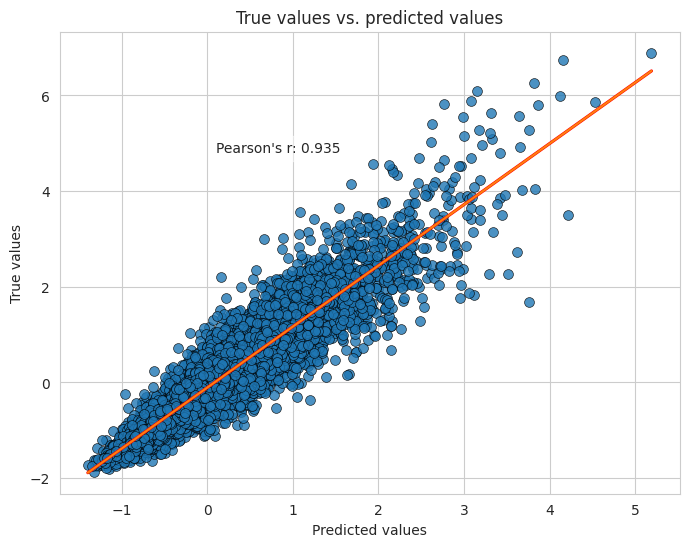

In [ ]:
#@title Plot true vs predicted values
import seaborn as sns
from scipy.stats import pearsonr

# Set Seaborn style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(8, 6))

sns.regplot(y=y_val, x=y_pred, scatter_kws={'s': 50, 'edgecolor': 'black', 'linewidth': 0.5}, line_kws={"color": "red"}, ci=None, scatter=True)

#Add titles
plt.title('True values vs. predicted values')
plt.xlabel('Predicted values')
plt.ylabel('True values')

#Fit a line of best fit to the data
coefficients = np.polyfit(y_pred, y_val, 1)  # 1 is the degree of the polynomial (i.e., a straight line)
line_function = np.poly1d(coefficients)
x_line = np.linspace(min(y_pred), max(y_pred), 100)
y_line = line_function(x_line)
plt.plot(x_line, y_line)

#Add Pearson's correlation coefficient
correlation_coefficient, _ = pearsonr(y_val, y_pred)
plt.text(0.1, 4.8, f"Pearson's r: {correlation_coefficient:.3f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

def regression_model2(input_dim):
  model = Sequential([
    #First hidden layer
    Dense(512, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.5), #Dropout for regularization

    #Second hidden layer
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5), #Dropout for regularization

    #Third hidden layer
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5), # Dropout for regularization

    #Output layer
    Dense(1, activation='linear')])
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
  return model

model = regression_model2(embeddings.shape[1])

#define early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
#train model
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
141/141 [==============================] - 11s 63ms/step - loss: 1.6966 - mae: 0.9854 - val_loss: 0.4327 - val_mae: 0.4556
Epoch 2/100
141/141 [==============================] - 7s 46ms/step - loss: 0.5461 - mae: 0.5569 - val_loss: 0.2700 - val_mae: 0.3695
Epoch 3/100
141/141 [==============================] - 8s 60ms/step - loss: 0.3191 - mae: 0.4216 - val_loss: 0.2389 - val_mae: 0.3434
Epoch 4/100
141/141 [==============================] - 7s 48ms/step - loss: 0.2609 - mae: 0.3793 - val_loss: 0.1972 - val_mae: 0.3122
Epoch 5/100
141/141 [==============================] - 8s 60ms/step - loss: 0.2344 - mae: 0.3581 - val_loss: 0.1936 - val_mae: 0.3155
Epoch 6/100
141/141 [==============================] - 7s 46ms/step - loss: 0.2205 - mae: 0.3467 - val_loss: 0.1818 - val_mae: 0.2947
Epoch 7/100
141/141 [==============================] - 9s 65ms/step - loss: 0.2077 - mae: 0.3350 - val_loss: 0.1912 - val_mae: 0.3133
Epoch 8/100
141/141 [==============================] - 8s 54m

In [ ]:
y_pred = model.predict(X_val)
y_pred = np.array([float(i) for i in y_pred])

report = regression_report(y_val, y_pred)
for key, value in report.items():
    if key != "Residuals":
        print(f"{key}: {round(value, 3)}")
    else:
        print(f"{key} (first 10): {value[:10]}")

425/425 [==============================] - 2s 5ms/step
R^2 Score: 0.883
Mean Absolute Error (MAE): 0.243
Root Mean Squared Error (RMSE): 0.339
Pearson Correlation coefficient: 0.943
Residuals (first 10): [-0.17260652 -0.29895124 -0.18417665 -0.45139717  0.3587725  -0.00132404
 -0.27776799  0.69194165 -0.13845149 -0.17998992]


In [ ]:
# Number of splits
n_splits = 5

# Define the K-fold cross-validator
kf = KFold(n_splits=n_splits)

X_train = X_train.to_numpy()

i=0
for train_index, val_index in kf.split(X_train):
    X_training, X_valid = X_train[train_index], X_train[val_index]
    y_training, y_valid = y_train[train_index], y_train[val_index]
    model = regression_model2(input_dim=X_train.shape[1])
    model.fit(X_training, y_training, epochs=50, validation_data=(X_valid, y_valid))
    print(model.evaluate(X_val, y_val))
    model.save(f"model_fold_{i}.h5")
    i += 1


Epoch 1/50
1125/1125 [==============================] - 27s 22ms/step - loss: 0.7512 - mae: 0.6225 - val_loss: 0.1987 - val_mae: 0.3386
Epoch 2/50
1125/1125 [==============================] - 23s 21ms/step - loss: 0.3076 - mae: 0.4074 - val_loss: 0.1716 - val_mae: 0.3101
Epoch 3/50
1125/1125 [==============================] - 26s 23ms/step - loss: 0.2789 - mae: 0.3889 - val_loss: 0.1580 - val_mae: 0.3002
Epoch 4/50
1125/1125 [==============================] - 28s 25ms/step - loss: 0.2706 - mae: 0.3826 - val_loss: 0.1709 - val_mae: 0.3161
Epoch 5/50
1125/1125 [==============================] - 31s 28ms/step - loss: 0.2622 - mae: 0.3750 - val_loss: 0.1473 - val_mae: 0.2820
Epoch 6/50
1125/1125 [==============================] - 24s 22ms/step - loss: 0.2529 - mae: 0.3694 - val_loss: 0.1319 - val_mae: 0.2676
Epoch 7/50
1125/1125 [==============================] - 22s 20ms/step - loss: 0.2501 - mae: 0.3658 - val_loss: 0.1419 - val_mae: 0.2721
Epoch 8/50
1125/1125 [==========================

In [ ]:
predictions = []

for i in range(0,5):
    loaded_model = load_model(f"models/MAPSS_prediction_ablang_seq_embeddings/model_fold_{i}.h5")
    predictions.append(loaded_model.predict(X_val))

average_predictions = np.mean(predictions, axis=0)

425/425 [==============================] - 1s 2ms/step


In [ ]:
y_pred = np.array([float(i) for i in average_predictions])

report = regression_report(y_val, y_pred)
for key, value in report.items():
    if key != "Residuals":
        print(f"{key}: {round(value, 3)}")
    else:
        print(f"{key} (first 10): {value[:10]}")

R^2 Score: 0.887
Mean Absolute Error (MAE): 0.242
Root Mean Squared Error (RMSE): 0.333
Pearson Correlation coefficient: 0.943
Residuals (first 10): [-0.22141653 -0.54913845 -0.25995973 -0.42651861  0.32994797 -0.02479994
 -0.46448365  0.75700643 -0.14487955 -0.28593836]
